<u>Classification Plan</u>
- 1st Training phase: Train a classifier on the first two labeled years of the data
- 2nd Training phase: Use the classifier and batch active learning on the rest of the unlabeled data until 2021. Examples that would provide the most information will be chosen to get their true label. The remaining examples will get pseudo-labeled
- 1st Evaluate phase: Use the newly trained classifier to evaluate the data from 2021 and 2022
- Predict phase: Use time series forecasting (RNN) to predict a country's set of features until 2050
- 2nd Evaluate phase: Use the classifier to predict levels of CN

In [ ]:
# Batch Active Learning
def train_labeled(classifier, lab_data, lab_label, epoch):
    """Train on the current labeled dataset

    Parameters:
    - classifier (classifier type): classifier-in-training
    - lab_data (ndarray): current labeled data, shape=(# of years, 83, 9)
    - lab_label (ndarray): labels for current labeled data, shape=(# of years, 83)
    - epoch (int): cycles to run the training for

    Returns:
    - classifier (classifier type): trained classifier
    """
    for _ in range(epoch):
        # Labeled examples have to be concatenated because not every
        # year's worth of data contains examples of every class
        # ex. If the classifier trains on data belonging to
        # only 8/11 classes, predict_proba() will only return
        # probabilities for these 8/11 classes and will ignore
        # the possibility of the 3 others
        labeled_examples = np.concatenate(lab_data, axis=0)
        labels = np.concatenate(lab_label, axis=0)
        # labeled_examples.shape = (# of years * 83, 9)
        # labels.shape = (# of years * 83,)
        classifier.fit(labeled_examples, labels)

    return classifier

def predict_unlabeled(classifier, batch_data):
    """Predict on the unlabeled data of a year
    
    Parameters:
    - classifier (classifier type): a trained classifier
    - batch_data (ndarray): a year's worth of unlabeled data, shape=(83, 9)

    Returns:
    - pred_class (ndarray): array of predicted classes, shape=(83,)
    - pred_proba (ndarray): array of array of class probabilities, shape=(83, 6)
    """
    pred_class = np.array(classifier.predict(batch_data))
    pred_proba = np.array(classifier.predict_proba(batch_data))

    return pred_class, pred_proba
    
def batch_active_learning(classifier, lab_data, lab_label, unlab_data, unlab_label, confident_threshold, epoch):
    """Train a classifier using batch active learning
    
    Parameters:
    - classifier: a classifier from the scikit-learn (sklearn) module 
    - lab_data (ndarray): the labeled dataset, inital shape=(3, 83, 9)
    - lab_label (ndarray): the labled dataset's labels, inital shape=(3, 83)
    - unlab_data (ndarray): the unlabeled dataset, inital shape=(28, 83, 9)
    - unlab_label (ndarray): the unlabeled dataset's labels, inital shape=(28, 83)
    - confident_threshold (float): threshold for the algorithm to request labels
    - epoch (int): number of epoches training will last for

    Returns:
    - classifier (classifier type): trained classifier
    """

    index = 0
    episode = 1
    # classifier = train_labeled(classifier, lab_data, lab_label, epoch)
    while index < 28:
        print(f"Episode {episode}: ")

        classifier = train_labeled(classifier, lab_data, lab_label, epoch)

        # Predict on the next batch of unlabeled data
        # 1 year is a batch
        # 4 batches per episode
        batch_data = []
        batch_label = []
        for modifier in range(4):
            batch_data.append(unlab_data[index + modifier])
            batch_label.append(unlab_label[index + modifier])

        # np.shape(batch_data) = (4, 83, 9)
        # np.shape(batch_label) = (4, 83)

        pred_class = []
        pred_proba = []
        for batch in batch_data:
            prediction_class, pred_probability = predict_unlabeled(classifier, batch)
            pred_class.append(prediction_class)
            pred_proba.append(pred_probability)
        print(f"score: {classifier.score(np.concatenate(batch_data, axis=0), np.concatenate(batch_label, axis=0))}")

        # np.shape(pred_class) = (4, 83)
        # np.shape(pred_proba) = (4, 83, 6)

        # Choose which examples to request a true label for
        # For these examples, replace their predicted label with their true label
        # Remember that the order of examples in pred_class, pred_proba, batch_data, and batch_label are the same
        # Ex. The label information of the example at index 0 of batch_data is found at index 0 of the other arrays
        uncertain = 0
        # 4 cycles
        for i, batch_proba in enumerate(pred_proba):
            # 83 cycles
            for j, probas in enumerate(batch_proba):
                pred = np.max(probas)
                if pred < confident_threshold:
                    uncertain += 1
                    pred_class[i][j] = batch_label[i][j]

        print(f"{uncertain} label request(s) made")

        # Reshape batch_data and pred_class for np.append()
        # rbatch_data = np.reshape(batch_data, (1, 83, 9))
        # rpred_class = np.reshape(pred_class, (1, 83))

        # classifier = train_labeled(classifier, batch_data, pred_class, epoch)

        # Add the newly pseudo-labeled, and any true-labeled, examples to the labeled data set
        lab_data = np.append(lab_data, batch_data, axis=0)
        lab_label = np.append(lab_label, pred_class, axis=0)

        index += 4
        episode += 1

    # Train one last time with all the passed examples, labeled and pseudo-labeled
    classifier = train_labeled(classifier, lab_data, lab_label, epoch)
        
    return classifier

In [ ]:
# Batch active learning hyperparameters aka model parameters
# These are different from real model parameters that are estimated by the model itself

n_estimators = 1000
max_iter = 1000
learning_rate = 0.01
max_depth = 50
confident_threshold = 0.70
epoch = 1
n_classes = 11
n_queries = 5

In [ ]:
# 1st Training phase: Train a classifier on the first two labeled years of the data
# 2nd Training phase: Use the classifier and batch active learning on the rest of the unlabeled data until 2021. Examples that would provide the most 


# Gaussian Naive Bayes isn't an option because the data distribution isn't gaussian/normal due to lacking a "symmetric bell shape". 
# Most of the data labels are on the high end of the scale. Thus, the data's bell shape isn't symmetric
# Bernoulli Naive Bayes isn't an option because sample features must be binary-valued (Bernoulli, boolean)
# Multinomial, Complement, and Categorical aren't considered  due to data being classified moreso out of probability rather than certainty.

classifier = RandomForestClassifier(n_estimators=n_estimators, criterion="log_loss", max_depth=max_depth)

# classifier = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=learning_rate, max_depth=max_depth)

classifier = batch_active_learning(classifier, 
                                   np.copy(lab_set), np.copy(lab_set_label), 
                                   np.copy(unlab_set), np.copy(unlab_set_label), 
                                   confident_threshold, epoch)

In [ ]:
# RNN classifier class
class RecurrentNeuralNetwork(nn.Module):
    def __init__(self):
        super(RecurrentNeuralNetwork, self).__init__()
        self.linear1 = nn.Linear(in_features=8, out_features=16)
        # nn.ReLU() doesn't need parameters in this case
        self.activation1 = nn.ReLU()
        self.linear2 = nn.Linear(in_features=16, out_features=16)
        self.activation2 = nn.ReLU()
        self.linear3 = nn.Linear(in_features=16, out_features=16)
        self.activation3 = nn.ReLU()
        # self.batchNorm = nn.BatchNorm1d()
        # self.flatten = nn.Flatten()
        # self.dropout1 = nn.Dropout()
        self.dense1 = nn.Linear(in_features=16, out_features=1)
        # self.dropout2 = nn.Dropout()
        # self.dense2 = nn.Linear()
        # self.dropout3 = nn.Dropout()
        # self.dense3 = nn.Linear()
        # self.softmax = nn.Softmax()

    def forward(self, x):
        x = self.linear1(x)
        x = self.activation1(x)
        x = self.linear2(x)
        x = self.activation2(x)
        x = self.linear3(x)
        x = self.activation3(x)
        # x = self.batchNorm(x)
        # x = self.flatten(x)
        # x = self.dropout1(x)
        x = self.dense1(x)
        # x = self.dropout2(x)
        # x = self.dense2(x)
        # x = self.dropout3(x)
        # x = self.dense3(x)

        return x

In [ ]:
a = np.array([[[0, 1],
               [2, 3],
               [4, 5]],
              [[6, 7],
               [8, 9],
               [10, 11]],
              [[12, 13],
               [14, 15],
               [16, 17]],
              [[18, 19],
               [20, 21],
               [22, 23]],
              [[24, 25],
               [26, 27],
               [28, 29]]])

print(a.shape)

a = np.transpose(a, [1, 0, 2])

print(a.shape)

a

In [18]:
import numpy as np
x = np.random.random((2, 4))
print(x)
y = x[:, 0:2]
print(y)
z = x[:, 2:]
print(z)

[[0.44548069 0.15105972 0.2186052  0.08444902]
 [0.8420005  0.49285142 0.51856099 0.30856119]]
[[0.44548069 0.15105972]
 [0.8420005  0.49285142]]
[[0.2186052  0.08444902]
 [0.51856099 0.30856119]]


In [ ]:
x = np.random.random((2, 3))
print(x)
y = scaler.fit_transform(x)
print(y)
z = scaler.inverse_transform(y)
print(z)

In [ ]:
us = pd.DataFrame(all_tsf[75], columns=["Oil", "Gas", "Coal", "Nuclear", "Hydro", "Solar", "Wind", "Geothermal", "Biofuel"])
x = np.array(us.index) + 1990
x2 = np.array(us.index) + 2023
y = [36.5] * 33
plt.plot(x, us["Oil"])
plt.plot(x2, y)
# plt.plot(x, us["Solar"])
plt.show()

In [ ]:
b = np.random.random((1, 9))
t = np.expand_dims(b, axis=0)
t.shape

In [ ]:
a = np.array([2, 3, -1, -4, 3])
a.clip(min=0)

In [1]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [2]:
filename = "GOOG.csv"
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251 entries, 0 to 250
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       251 non-null    object 
 1   Open       251 non-null    float64
 2   High       251 non-null    float64
 3   Low        251 non-null    float64
 4   Close      251 non-null    float64
 5   Adj Close  251 non-null    float64
 6   Volume     251 non-null    int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 13.9+ KB
None


In [5]:
df['Date'] = pd.to_datetime(df['Date'])
df = df.set_axis(df['Date'])
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

In [6]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

200
51


In [7]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [8]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)



Epoch 1/25


C:\Users\Andre\AppData\Local\Temp\ipykernel_2168\3162532282.py:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_generator, epochs=num_epochs, verbose=1)



10/10 [==============================] - 1s 3ms/step - loss: 11554.5381
Epoch 2/25
10/10 [==============================] - 0s 3ms/step - loss: 11426.9717
Epoch 3/25
10/10 [==============================] - 0s 3ms/step - loss: 11293.7666
Epoch 4/25
10/10 [==============================] - 0s 3ms/step - loss: 11141.2334
Epoch 5/25
10/10 [==============================] - 0s 3ms/step - loss: 10985.4990
Epoch 6/25
10/10 [==============================] - 0s 3ms/step - loss: 10815.8350
Epoch 7/25
10/10 [==============================] - 0s 3ms/step - loss: 10631.1152
Epoch 8/25
10/10 [==============================] - 0s 3ms/step - loss: 10181.3779
Epoch 9/25
10/10 [==============================] - 0s 3ms/step - loss: 4897.7959
Epoch 10/25
10/10 [==============================] - 0s 3ms/step - loss: 3198.6125
Epoch 11/25
10/10 [==============================] - 0s 3ms/step - loss: 8449.4941
Epoch 12/25
10/10 [==============================] - 0s 3ms/step - loss: 8191.8394
Epoch 13/25
10/

In [16]:
close_data = close_data.reshape((-1))

print(close_data.shape)

def predict(num_prediction, model):
    # close_data.shape ~= (500,)
    # num_prediction = 30
    # look_back = 15
    # The last 15 elements of close_data
    prediction_list = close_data[-look_back:]
    print(prediction_list.shape)
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        print(f"x.shape: {x.shape}")
        x = x.reshape((1, look_back, 1))
        print(f"x.reshape: {x.shape}")
        out = model.predict(x)
        print(f"1st out.shape: {out.shape}")
        out = out[0][0]
        print(f"2nd out.shape: {out.shape}")
        print(f"out: {out}")
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]

    print(f"prediction_list.shape: {prediction_list.shape}")
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)

(251,)
(15,)
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 17ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 101.56218719482422
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 19ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 86.59120178222656
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 18ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 90.86072540283203
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 18ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 81.2593994140625
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 19ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 91.72211456298828
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] - 0s 18ms/step
1st out.shape: (1, 1)
2nd out.shape: ()
out: 104.33345794677734
x.shape: (15,)
x.reshape: (1, 15, 1)
1/1 [==============================] 

In [29]:
c = np.arange(15)
print(c)
c = np.append(c, (np.arange(30) + 15))
print(c)
print(c[15-1:])
c.shape

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44]
[14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37
 38 39 40 41 42 43 44]


(45,)

In [ ]:
w = np.array([[2, 3], [4, 5]])
np.save("data/w", w)

In [ ]:
p = np.load("data/w.npy")
print(type(p))
print(p.shape)
print(p)

[[ 0.07786339]
 [-0.03961813]
 [ 0.01103904]
 [-0.04069594]
 [-0.03422907]
 [ 0.00564998]
 [ 0.08864151]
 [-0.03315126]
 [-0.05686312]
 [-0.03099563]
 [ 0.05522933]
 [-0.06009656]
 [ 0.00133873]
 [-0.02345095]
 [-0.07410811]
 [ 0.01966154]
 [-0.01590626]
 [-0.01590626]
 [ 0.03906215]
 [-0.0730303 ]]
[225.9732401  115.74763374 163.27610621 114.73638965 120.80385422
 158.21988574 236.08568105 121.81509832  99.56772822 123.83758651
 204.73711411  96.53399594 154.17490936 130.91629517  83.3878227
 171.36605897 137.99500384 137.99500384 189.56845268  84.3990668 ]
Coefficients: 
 [938.23786125]
Root mean squared error: 50.48
Coefficient of determination: 0.47


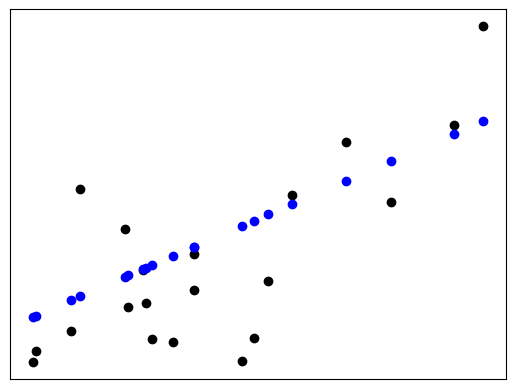

In [17]:

import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Load the diabetes dataset
diabetes_X, diabetes_y = datasets.load_diabetes(return_X_y=True)

# Use only one feature
diabetes_X = diabetes_X[:, np.newaxis, 2]

# Split the data into training/testing sets
diabetes_X_train = diabetes_X[:-20]
diabetes_X_test = diabetes_X[-20:]

# Split the targets into training/testing sets
diabetes_y_train = diabetes_y[:-20]
diabetes_y_test = diabetes_y[-20:]

# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
regr.fit(diabetes_X_train, diabetes_y_train)

# Make predictions using the testing set
diabetes_y_pred = regr.predict(diabetes_X_test)

print(diabetes_X_test)
print(diabetes_y_pred)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Root mean squared error: %.2f" % sqrt(mean_squared_error(diabetes_y_test, diabetes_y_pred)))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.2f" % r2_score(diabetes_y_test, diabetes_y_pred))

# Plot outputs
plt.scatter(diabetes_X_test, diabetes_y_test, color="black")
plt.scatter(diabetes_X_test, diabetes_y_pred, color="blue")

plt.xticks(())
plt.yticks(())

plt.show()

In [12]:
import numpy as np
from sklearn.linear_model import LinearRegression
X = np.array([[1, 1], [1, 2], [2, 2], [2, 3]])
# y = 1 * x_0 + 2 * x_1 + 3
y = np.dot(X, np.array([1, 2])) + 3
print(y)
reg = LinearRegression().fit(X, y)
reg.score(X, y)
z = reg.predict(np.array([[2, 3]]))
print(z)


[ 6  8  9 11]
[11.]


In [ ]:
# Baseline Phase: Predict the future using linear regression

baseline_train = []
baseline_test = []
for country in all_tsf:
    # country.shape = (33, 9), 33 rows and 9 columns

    # No normalization performed for linear regression

    # For each country/region, split their data into 3/4 and 1/4, 
    # where 3/4 is the training set and 1/4 is the test set
    # First 25 years
    train = country[:25]
    # Everything after
    test = country[25:]

    # Recall that the # of years dimension decreases by 1
    # in series_to_supervised()
    reframed_train = series_to_supervised(train).values
    reframed_test = series_to_supervised(test).values
    # reframed_*.shape = (# of years, 18), # of years rows and 18 columns
    # columns 0-8: t-1 for each feature
    # columns 9-17: t for each feature
    baseline_train.append(reframed_train)
    baseline_test.append(reframed_test)
    
baseline_train = np.array(baseline_train)
baseline_test = np.array(baseline_test)
# baseline_train.shape = (83, 24, 18)
# baseline_test.shape = (83, 7, 18)

rmse = []
for index in range(len(cotry_reg)):
    train: np.ndarray = baseline_train[index]
    # train_tsf.shape = (24, 18)
    train_X, train_y = train[:, :9], train[:, 9:]
    # train_*.shape = (24, 9)

    test: np.ndarray = baseline_test[index]
    # test_tsf.shape = (7, 18)
    test_X, test_y = test[:, :9], test[:, 9:]
    # test_*.shape = (7, 9)

    ind_rmse = []
    for i in range(9):
        rtrain_X = train_X[:, i].reshape(-1, 1)
        rtest_X = test_X[:, i].reshape(-1, 1)
        # rtrain_X.shape = (24, 1)
        # rtest_X.shape = (7, 1)

        regr = LinearRegression()
        # train_y[:, i].shape = (24,)
        regr.fit(rtrain_X, train_y[:, i])

        pred_y = regr.predict(rtest_X)
        # pred_y.shape = (7,)

        ind_rmse.append(sqrt(mean_squared_error(test_y[:, i], pred_y)))

    rmse.append(ind_rmse)

# rmse.shape = (83, 9)
avg_rmse = []
for r in rmse:
    avg_rmse.append(np.mean(r))

# avg_rmse.shape = (83,)
for index in range(len(cotry_reg)):
    print(f"{cotry_reg[index]} average rmse: {avg_rmse[index]}")